In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from matplotlib import gridspec 


from matplotlib.lines import Line2D
import pickle

In [9]:

d = -1
u = 1

rna = pd.DataFrame()
for f in ['AR', 'SMARCC2sg1', 'SMARCC2sg2', 'GSE138460', 'GSE123379', 'SMARCC2']:
	tmp = pd.read_table(f"data/rna/deg/{f}.tsv")
	tmp["log2FoldChange"] *= -1
	tmp["Dataset"] = f

	tmp['DE'] = 'NS'

	tmp.loc[(tmp["log2FoldChange"] > u) & (tmp["padj"] < 0.05), "DE"] = "Pos"
	tmp.loc[(tmp["log2FoldChange"] < d) & (tmp["padj"] < 0.05), "DE"] = "Neg"


	rna = pd.concat([rna, tmp])

rna["lQ"] = -np.log10(rna["padj"])
rna = rna[~rna["lQ"].isna()]

/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


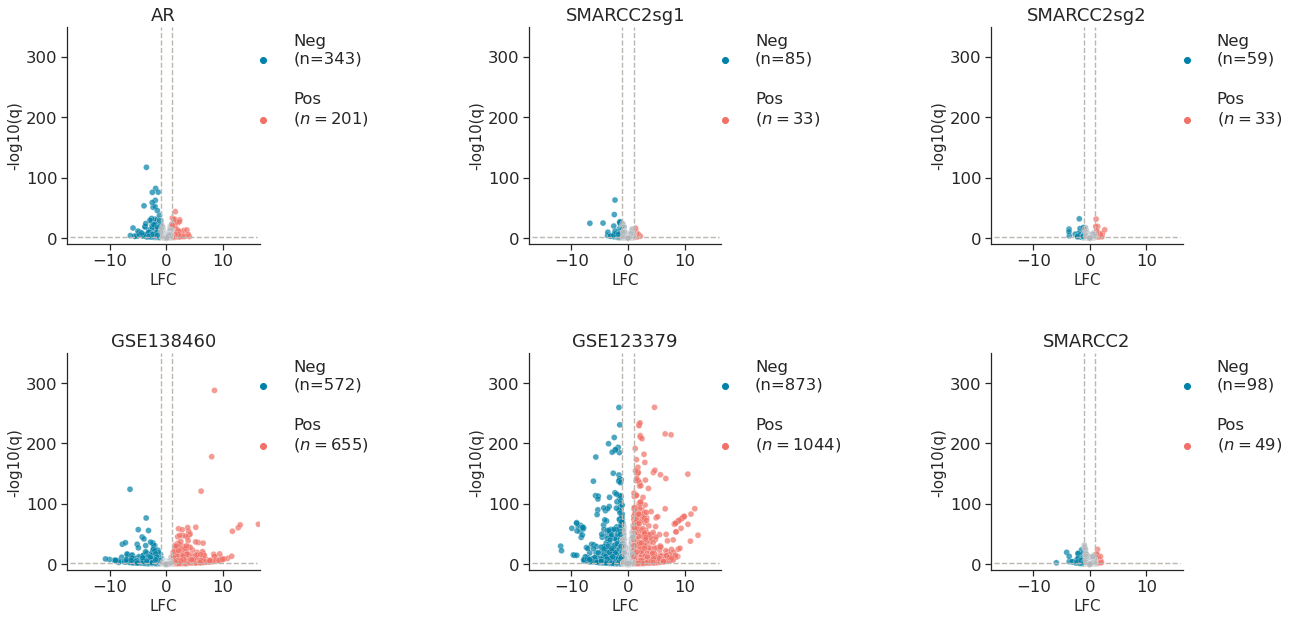

In [48]:
fig = plt.figure(figsize=[20,10])
gs = gridspec.GridSpec(nrows=2, ncols=3)
plt.subplots_adjust(hspace=0.5, wspace=1.4)

sns.set(style="ticks", font_scale=1.5)

for i, c in enumerate(rna['Dataset'].unique()):
	fig.add_subplot(gs[i])
	d = rna[(rna["Dataset"] == c)]
	g = sns.scatterplot(data=d, 
					x="log2FoldChange", 
					y="lQ", 
					hue="DE", 
					hue_order=["Neg", "NS", "Pos"], 
					palette = ["#0081a7", "#adb5bd", "#f07167"],
					linewidth=0.3,
					alpha=0.7
	)
	plt.title(c, fontsize=18)
	xlim = int(max(abs(rna["log2FoldChange"].min()), rna["log2FoldChange"].max() )) + 1
	plt.xlim([-xlim-0.5, xlim-0.5])

	handles, labels = g.get_legend_handles_labels()
	[handles[0],handles[2]]
	[labels[0],labels[2]]
	sns.despine()

	nneg = d.groupby("DE").size()["Neg"]
	npos = d.groupby("DE").size()["Pos"]

	g.legend(
		handles=[handles[0],handles[2]], 
		labels=[f"Neg\n(n={nneg})\n ", f"Pos\n$(n={npos})$\n"], 
		title="",
		bbox_to_anchor=(0.9, 1), 
		loc=2, 
		borderaxespad=0,
		frameon=False
	)

	
	plt.ylabel("-log10(q)", fontsize=15)
	plt.xlabel("LFC", fontsize=15)
	
	ylim = 350
	#ylim = int(d["lQ"].max())+5

	plt.plot(range(-xlim, xlim), [-np.log10(0.05) for i in range(-xlim, xlim)], color='#bcb8b1', linestyle='--',linewidth=1.4)
	plt.plot([ 1 for i in range(ylim)], range(ylim), color='#bcb8b1', linestyle='--',linewidth=1.4)
	plt.plot([-1 for i in range(ylim)], range(ylim), color='#bcb8b1', linestyle='--',linewidth=1.4)

	plt.ylim([-10, ylim])

sns.despine()



fig.savefig("plot/rna.volcano.pdf", bbox_inches="tight", pad_inches=1)


# Venns

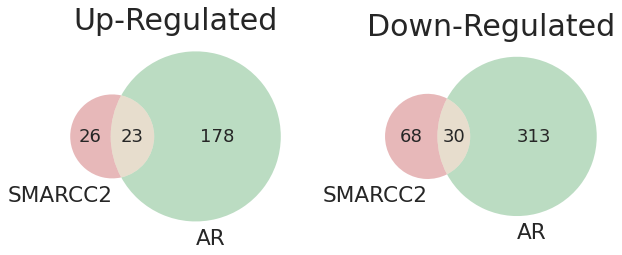

In [49]:

fig  = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
venn2((
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'SMARCC2'))].index),
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'AR'))].index)
), set_labels=('SMARCC2', 'AR'))
plt.title('Up-Regulated', fontsize=30)

fig.add_subplot(gs[1])
venn2((
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'SMARCC2'))].index),
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'AR'))].index)
), set_labels=('SMARCC2', 'AR'))
plt.title('Down-Regulated', fontsize=30)


fig.savefig("plot/rna.degvenn.pdf", bbox_inches="tight", pad_inches=1)

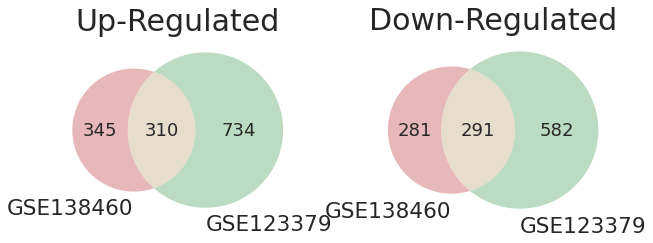

In [50]:

fig  = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
venn2((
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE138460'))].index),
	set(rna[((rna['DE'] == 'Pos') & (rna['Dataset'] == 'GSE123379'))].index)
), set_labels=('GSE138460', 'GSE123379'))
plt.title('Up-Regulated', fontsize=30)

fig.add_subplot(gs[1])
venn2((
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE138460'))].index),
	set(rna[((rna['DE'] == 'Neg') & (rna['Dataset'] == 'GSE123379'))].index)
), set_labels=('GSE138460', 'GSE123379'))
plt.title('Down-Regulated', fontsize=30)


fig.savefig("plot/rna.publicvenn.pdf", bbox_inches="tight", pad_inches=1)

291

# Heatmap

In [12]:
deg = rna.loc[(rna['Dataset'].isin(['SMARCC2', 'AR'])) & (rna['DE'] != 'NS'), ['Dataset', 'DE', 'log2FoldChange']]
tmp = deg[['Dataset', 'DE']].reset_index().groupby('index').size()

deg['GeneGroup'] = deg['Dataset']
deg.loc[tmp[tmp == 2].index, 'GeneGroup'] = 'Common'
deg


,Dataset,DE,log2FoldChange,GeneGroup
ABCA1,AR,Neg,-1.805559,AR
ACKR3,AR,Neg,-2.418619,AR
ACSL5,AR,Neg,-1.543172,AR
ACSM1,AR,Pos,1.822915,AR
ADGRB1,AR,Pos,1.623036,AR
...,...,...,...,...
TRIM43B,SMARCC2,Neg,-1.019933,Common
TTYH1,SMARCC2,Neg,-1.495013,SMARCC2
TXNIP,SMARCC2,Neg,-2.134804,Common
VSTM2L,SMARCC2,Neg,-1.543721,SMARCC2


In [13]:

order = deg.sort_values(["GeneGroup", "DE",  "log2FoldChange"], ascending=False)
orderGenes = list(order.index)


In [14]:
mat = pd.read_table('data/rna/normalized.tsv')
mat

Mat = mat.loc[orderGenes,:]

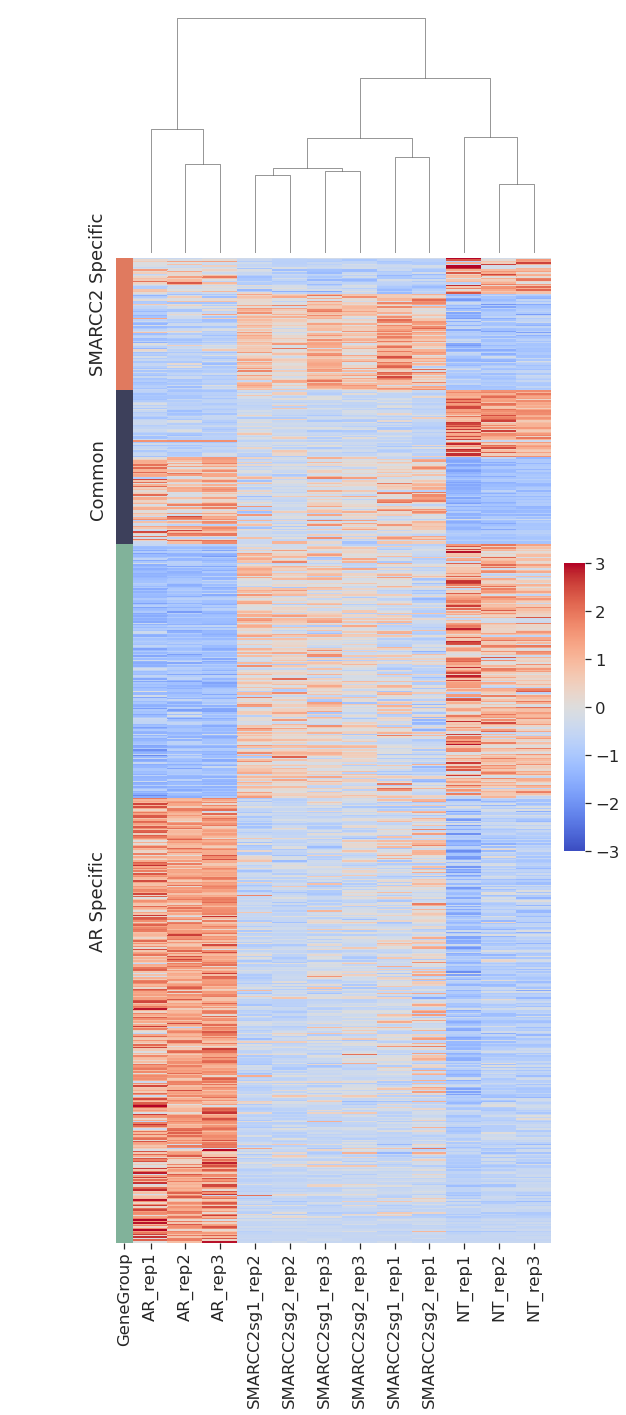

In [51]:
lut = dict(zip(order["GeneGroup"].unique(),["#e07a5f", "#3d405b", "#81b29a"]))
row_colors = order["GeneGroup"].map(lut)




cl = sns.clustermap(
    Mat,
    z_score=0,
    row_colors=row_colors, cmap="coolwarm", figsize=[10,20],
    row_cluster=False,
    col_cluster=True,
    vmax=3, vmin=-3,
    cbar_pos=(0.8, 0.4, 0.03, 0.2)
                
)

cl.cax.text(-130,-5, "AR Specific", ha="right", rotation=90)
cl.cax.text(-130,4, "Common",  ha="right", rotation=90)
cl.cax.text(-130,7, "SMARCC2 Specific",  ha="right", rotation=90)

cl.ax_heatmap.set_yticks([])


fig.savefig("plot/rna.degheatmap.pdf", bbox_inches="tight", pad_inches=1)

# Gene Expression of AR and SMARCC2

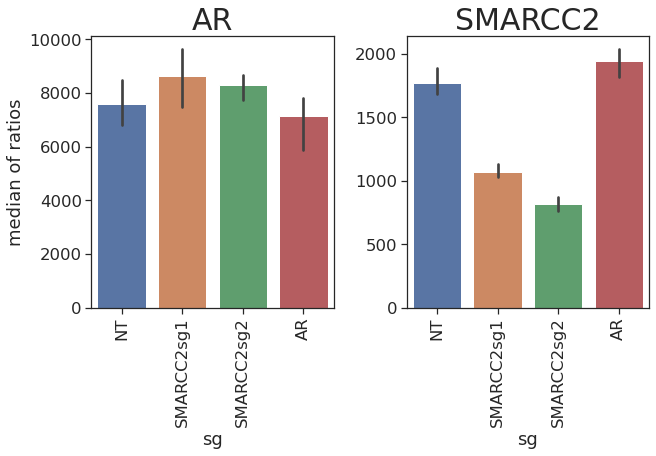

In [52]:

fig  = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.3)

fig.add_subplot(gs[0])
tmp = mat.loc['AR',:].reset_index()
tmp['sg'] = tmp['index'].str.split('_',expand=True)[0]
sns.barplot(data=tmp, x='sg', y='AR', order=['NT', 'SMARCC2sg1', 'SMARCC2sg2', 'AR'])
plt.title('AR',fontsize=30)
plt.xticks(rotation=90)
plt.ylabel('median of ratios')


fig.add_subplot(gs[1])
tmp = mat.loc['SMARCC2',:].reset_index()
tmp['sg'] = tmp['index'].str.split('_',expand=True)[0]
sns.barplot(data=tmp, x='sg', y='SMARCC2', order=['NT', 'SMARCC2sg1', 'SMARCC2sg2', 'AR'])
plt.xticks(rotation=90)
plt.title('SMARCC2',fontsize=30)
plt.ylabel('')


fig.savefig("plot/rna.tfexp.pdf", bbox_inches="tight", pad_inches=1)


# GSEA

In [110]:

mat = pd.read_table('data/rna/normalized.tsv')
meta = pd.read_table("data/rna/metadata.tsv")
meta = meta[meta['Dataset'] == 'BG'].reset_index(drop='True')

In [111]:

for sg in ["AR", "SMARCC2sg1"]:
    filename = f"data/rna/gsea/{sg}.gct"
    
    cols = meta.loc[meta['Target'] == 'NT', 'Name'].tolist() + meta.loc[meta['Target'] == sg, 'Name'].tolist() 
    
    tmp = mat[cols]
    tmp = tmp.astype(str)
    with open(filename, "w") as f:
        f.write("#1.2\n")
        f.write(f"{tmp.shape[0]}\t{tmp.shape[1]}\n")
        f.write(f"NAME\tdecsription\t" + "\t".join(cols) + "\n")
        for name, row in tmp.iterrows():
            line = name +"\tNA\t" +"\t".join(row.tolist()) + "\n"
            f.write(line)
            

# BAF regions around the genes

In [47]:
%%bash

annot=/groups/lackgrp/genomeAnnotations/hg38/hg38.ncbiRefSeq.simple.gtf

bedtools window -a <(tail -n+2 data/chip/baf.bed | sort -k1,1 -k2,2n ) -b $annot -w 100000 > data/chip/baf.gene/window.100k

grep "transcript" data/chip/baf.gene/window.100k > data/chip/baf.gene/window.100k.coding


In [17]:


windows = {} 
ncs = {"gBAF":[], "rBAF":[], "gSMA":[]}
genesbed = {} 
with open("data/chip/baf.gene/window.100k.coding","r") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        name, meta, Chr, Start, End = row[3], row[12], row[4], row[7], row[8]
        genename = meta[meta.index("gene_name"):].split("\"")[1]
        genesbed[genename] = (Chr, Start, End)
        if name not in windows:
            windows[name] = [genename]
        else:
            windows[name].append(genename)
            
        nc = name.split(".")[-1]
        ncs[nc].append(genename)
        

        
geneBED = pd.DataFrame(genesbed).T.rename(columns={0:"Chr", 1:"Start", 2:"End"})            
            
            
genesnc = {k:set(v) for k,v in ncs.items()}

for k, v in windows.items():
	windows[k] = list(set(v))



In [19]:
deg_our = list(deg[deg['Dataset'] == 'SMARCC2'].index)

DEpeaks_our = {}

for name, genes in windows.items():
    
    tmp = any([_ in deg_our for _ in genes])
    
    if tmp:
        DEpeaks_our[name] = set([_ for _ in genes if _ in deg_our])
    
    
uni_our = list()

for k, v in DEpeaks_our.items():
    s_ = k.split('.')[1]
    if s_ != 'gBAF':
        continue
    else:
        uni_our += list(v)
        

len(set(uni_our))




In [38]:
u_public = list(set(rna[(rna['Dataset'] == 'GSE138460') & (rna['DE'] == 'Pos')].index).intersection(rna[(rna['Dataset'] == 'GSE123379') & (rna['DE'] == 'Pos')].index))

d_public = list(set(rna[(rna['Dataset'] == 'GSE138460') & (rna['DE'] == 'Neg')].index).intersection(rna[(rna['Dataset'] == 'GSE123379') & (rna['DE'] == 'Neg')].index))


deg_public = u_public + d_public

DEpeaks_public = {}

for name, genes in windows.items():
    
    tmp = any([_ in deg_public for _ in genes])
    
    if tmp:
        DEpeaks_public[name] = set([_ for _ in genes if _ in deg_public])
    
    
uni_public = list()

for k, v in DEpeaks_public.items():
    s_ = k.split('.')[1]
    if s_ != 'gBAF':
        continue
    else:
        uni_public += list(v)
        

len(set(uni_public))
        

497

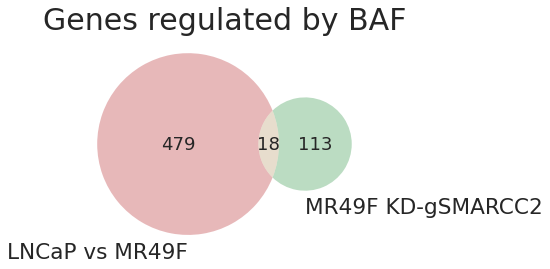

In [53]:
venn2((set(uni_public), set(uni_our)), set_labels=('LNCaP vs MR49F', 'MR49F KD-gSMARCC2'))

plt.title('Genes regulated by BAF', fontsize=30)


fig.savefig("plot/rna.baf.pdf", bbox_inches="tight", pad_inches=1)
